> By Jiahui Tang

**Spec**:

* GPU: AWS GPU g3.4xlarge, Tesla M60 (More details attached)
* OS: Ubuntu 18.04
* Kernel: Linux ip-172-31-36-197 5.4.0-1039-aws #41~18.04.1-Ubuntu SMP Fri Feb 26 11:20:14 UTC 2021 x86_64 x86_64 x86_64 GNU/Linux
* EBS: Resize EBS Volume to 128GB 
* Compiler: gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0 (no flags)

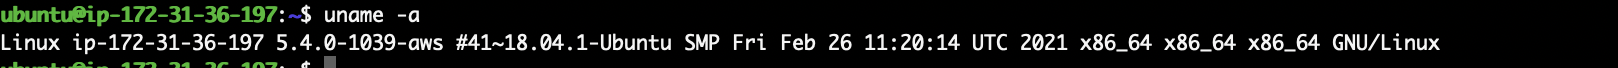
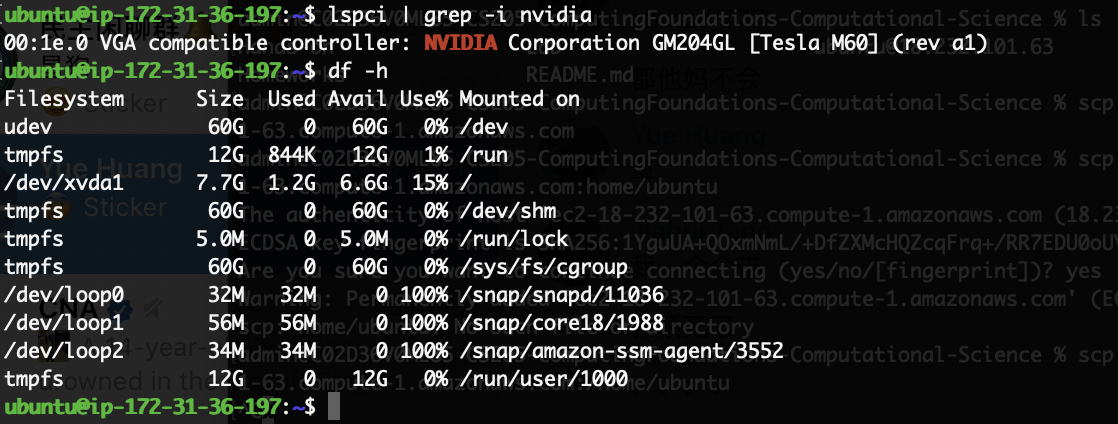
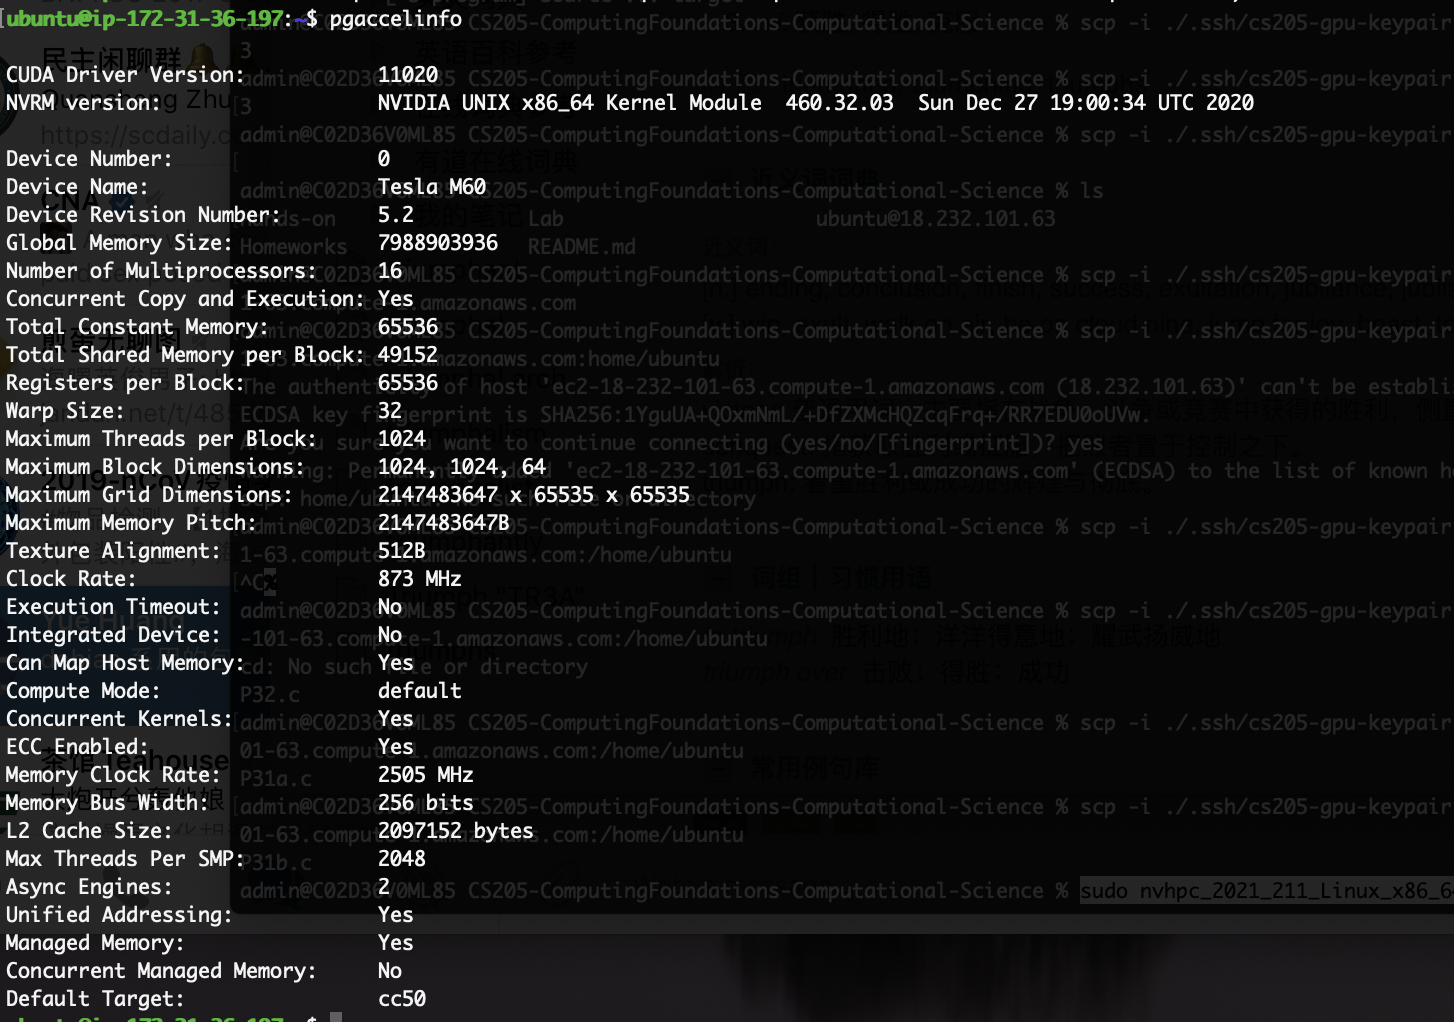
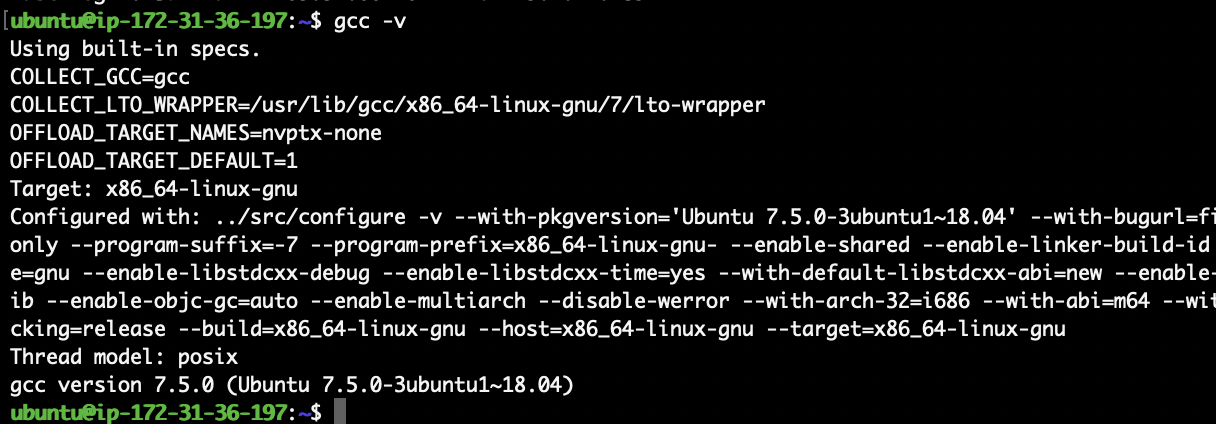
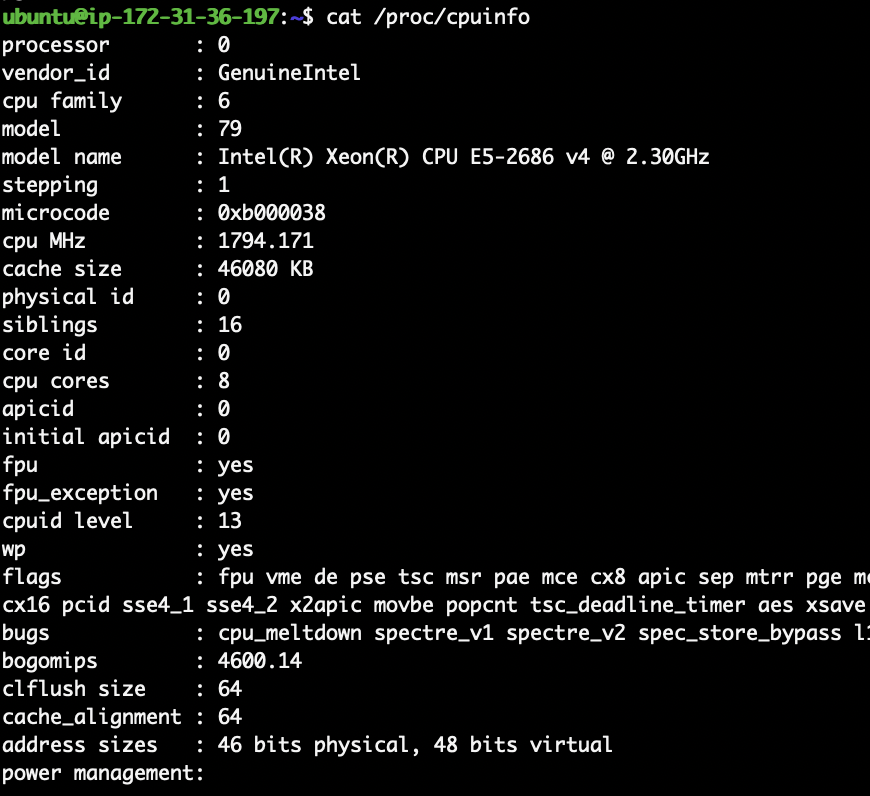

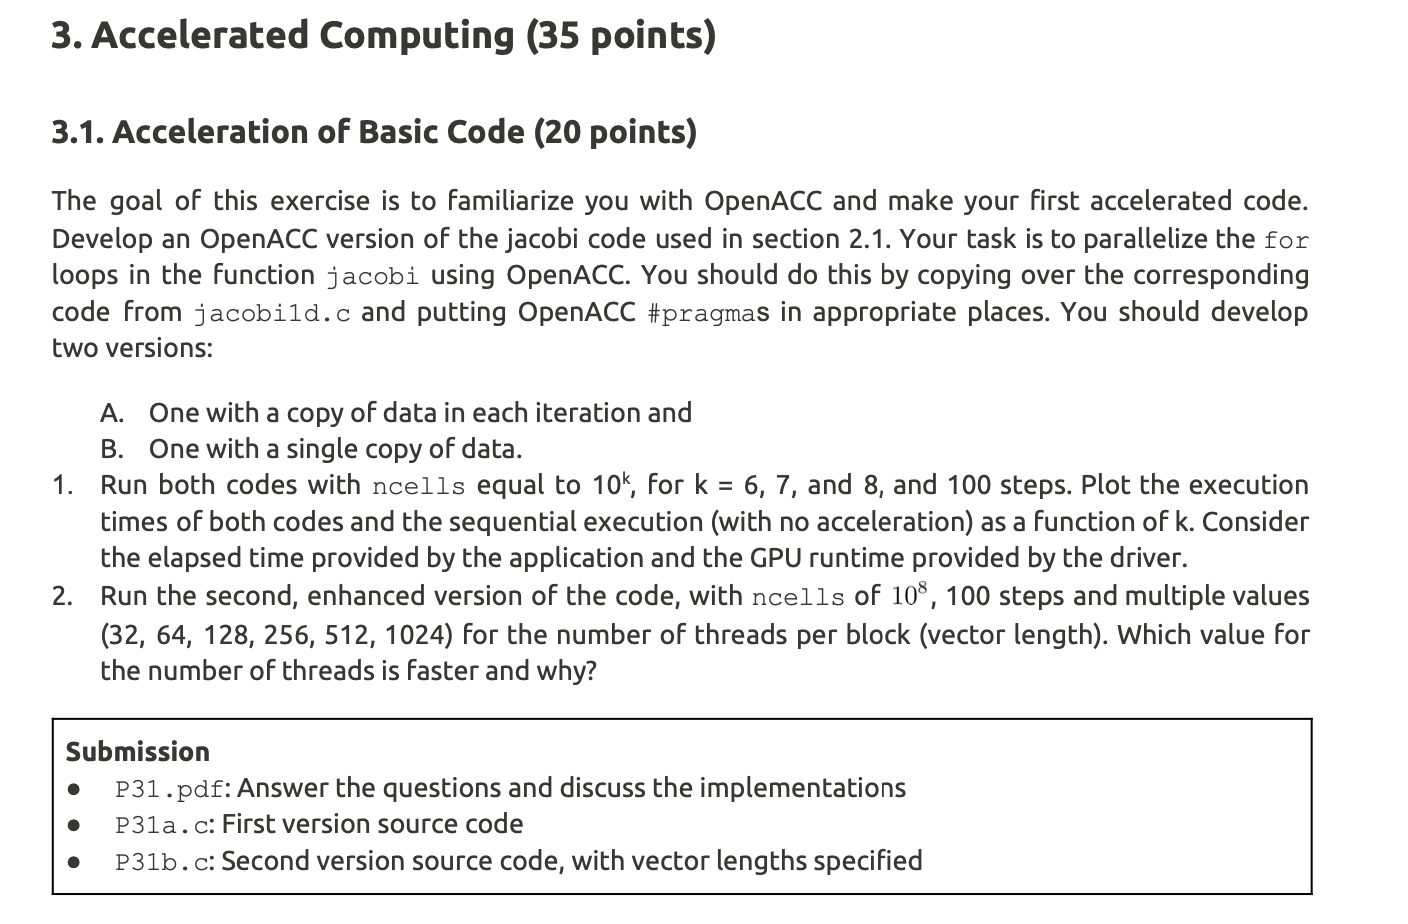

**Dicuss the implementation:**
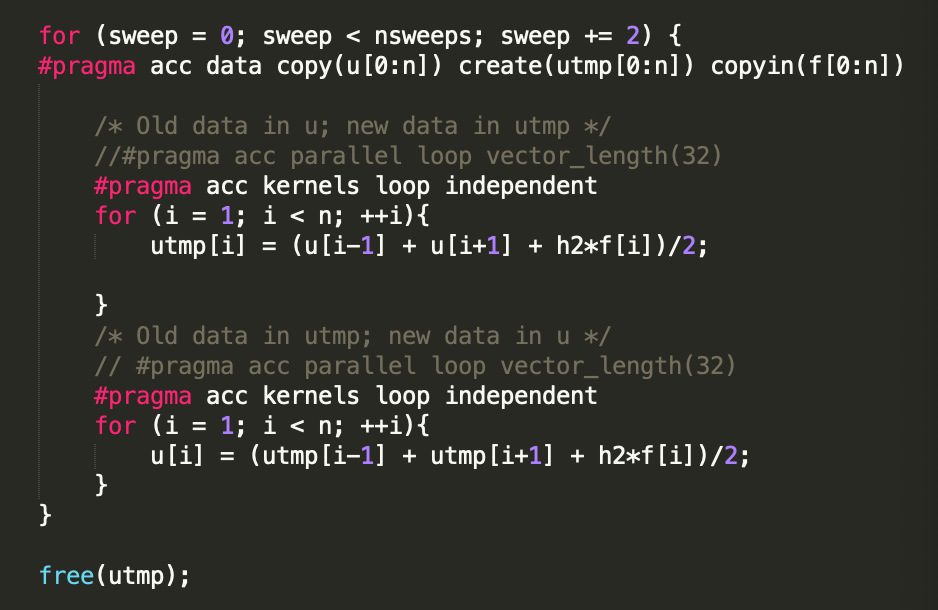
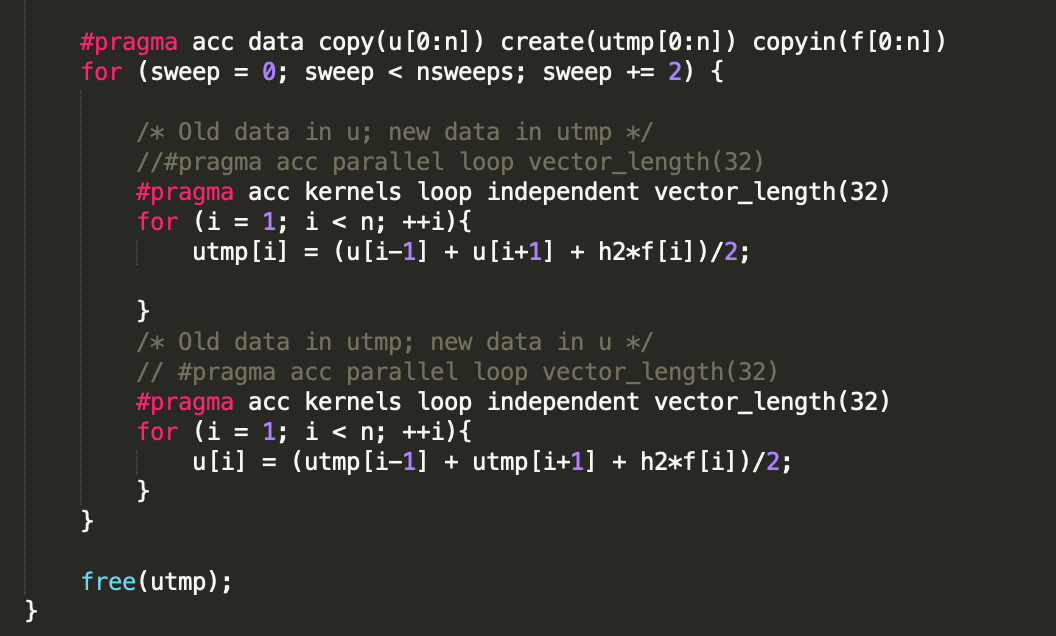

For implementation, 
1. `#pragma acc data copy(u[0:n]) create(utmp[0:n]) copyin(f[0:n])`

For `#pragma acc data`, in order to optimize jacobi() function and copying data for iterations, we put the data optimziation inside/outside the outer for loop for version A and B. 

   * matrix u: It is defined before the for loop, and will be changed inside the inner two for loops, and will also be an output after executing for loops, so we use copy clause for both copy in and export. 
   * utmp matrix: It is a temporary matrix that only storage intermediate value inside two for loops. By using create clause, we could pre-allocate space for him, but it's a temporary variable and we don't need output. 
   * f matrix: the f matrix information is used when running two inner for loops, so we need copyin to send its data into the parallel processing. But there's no output for f matrix needed, as its value is not changed. So we use only `copyin` instead of `copy`
   * [0:N]: since we want to make sure that length of space is appropriately allocated for the elements in matrix, we explicitly specify the index and length.


2. `#pragma acc kernels loop independent`

I tried to distinguish the difference between two different clauses
    * #pragma acc kernels loop
    * #pragma acc parallel loop

They could all be compiled but the main difference is that kernels construct may be thought of as a hint to the compiler of where it should look for parallelism, while the parallel directive is an assertion to the compiler of where there is parallelism. Thus, I put it as `#pragma acc kernels loop`.

As for `independent`, by using this construct in conjunction with the loop construct, we can tell the compiler that loop iterations are data-independent and can be executed in parallel, overriding compiler dependency analysis.


Version A requires one copy of data of each iteration, thus the `#pragma acc data copy(u[0:n]) create(utmp[0:n]) copyin(f[0:n])` is put inside the outer most loop; while version B require only one with a single copy of data, thus the `#pragma acc data copy(u[0:n]) create(utmp[0:n]) copyin(f[0:n])` is put outside the outer most loop to only keep one copy.

Reference:
* https://www.cs.ucdavis.edu/~matloff/OpenACCDir/Intros158/FuLinMiller.pdf (P7)
* https://www.openacc.org/sites/default/files/inline-files/OpenACC_Programming_Guide_0.pdf (p17)

**(Q1)**. Table for improvements in elapsed execution time 

(*unit: seconds*)

With `ncells = 10^k`, `step=100`,
For P31b.c Version B, we used `vector_size = 32` explicitly.

|       | k=6 Elpased Time |k=6 GPU Kernal Timing Data |  k=7 Elpased Time | k=7 GPU Kernal Timing Data| k=8 Elpased Time | k=8 GPU Kernal Timing Data | 
| ----------- | ----------- |----------- |----------- |----------- |----------- |----------- |
| *version A*: P31a.c |0.775286|0.239208|5.86755|2.344471|53.7508|23.567850|
| *version B*: P31b.c   | 0.310221|0.021626        |0.543963        |0.224418       |3.0322        |2.401439        
| *Sequential Execution*: jacob1d.c   | 0.107952        |N/A       |3.26706        |N/A     |32.8349        |N/A        |




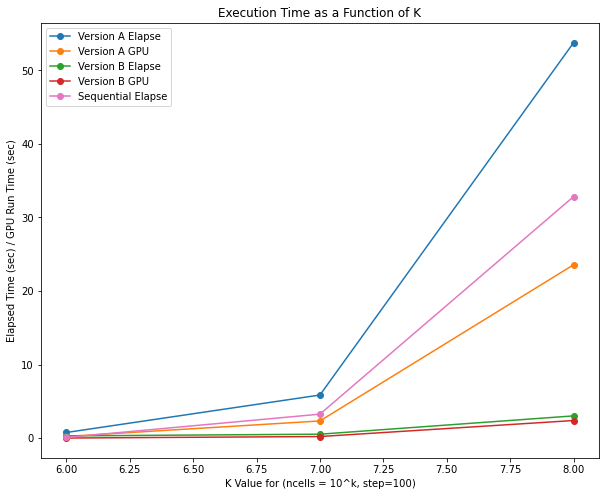

In [19]:
import matplotlib.pyplot as plt

k = [6,7,8]
ver_A_elapse = [0.775286, 5.86755, 53.7508]
ver_A_GPU = [0.239208,2.344471,23.567850]
ver_B_elapse = [0.310221, 0.543963, 3.0322]
ver_B_GPU = [0.021626,0.224418,2.401439]
sequential_elapse = [0.107952, 3.26706, 32.8349]


plt.figure(figsize = (10,8))
plt.plot(k, ver_A_elapse, '-ob', label = "Version A Elapse", color="tab:blue")
plt.plot(k, ver_A_GPU, '-ob', label = "Version A GPU",color="tab:orange")
plt.plot(k, ver_B_elapse, '-ob', label = "Version B Elapse",color = "tab:green")
plt.plot(k, ver_B_GPU, '-ob', label = "Version B GPU",color = "tab:red")
plt.plot(k, sequential_elapse, '-ob', label = "Sequential Elapse",color = "tab:pink")


plt.xlabel('K Value for (ncells = 10^k, step=100)')
plt.ylabel('Elapsed Time (sec) / GPU Run Time (sec)')
plt.title('Execution Time as a Function of K')
plt.legend()
plt.show()

We could observe that `Version A` takes the longest elapsed time and is the slowest for all level of K, even if it uses openAcc parallelizatoin to do accelerate computing. As it copies data at each iteration, copy data creates too much overhead, thus the performance and efficiency is even slower than pure `sequential` execution.

Next to Version A elapsed time, it followed by sequential code with no acceleration, then version A GPU time; The version B elapsed time and GPU time is the most effective one. 

We can also observe that GPU runtime provided by the driver is always less than elapsed time.

**(Q2)**
With `ncells = 10^8`, `step=100`

*Unit: Seconds*

| Number of Threads     | n=32 |n=64 | n=128 | n=256 |n=512| n=1024 | 
| ----------- | ----------- |----------- |----------- |----------- |----------- |----------- |
| *Elapsed Time* **version B**: P31b.c| 3.0744|3.01042 |2.93694        |2.86104        |2.81429  |2.7706    
| *GPU Driver Time* **version B**: P31b.c|  2.453468|2.390645       |2.330780        |2.251912       |2.203696        | 2.161270       



> We could see that as number of threads increases, the elapse time and GPU time also decrease and goes faster.

> It looks value `n=1024` for thread number is faster. When it divides matrix into the chunk, it divides 65535 grids into blocks of 1024 vector length. Vector length is number of threads in each gang/block. As worker is architecture specific, related to thread scheduling group, and we have 65535 grids, as number of threads in each gang/block increase, the num_gang(number of blocks in the grid) decreases. When `vector_size=1024, grid=65535`, `num_gang=64`.

> Looking at the device specific information for our NVIDIA Tesla M60, it has `32 warps (workers)` and `1024 maximum threads per block`. Thus we could see that fully utilize `32 warps` by setting `vector_size = 2048` might leads to even faster performance, as it uses all workers and didn't have reuse/communication/latency overheads. However, as the hard limit of max threads is 1024 here, the performance reaches best speed when thread number is 1024. It uses each of 32 workers twice. If we set thread number smaller than 1024, it will have to reuse 32 workers for multiple times and there might be some overheads in data transfer or communciation, making it slightly slower.

> Thus the best thread here is `1024`
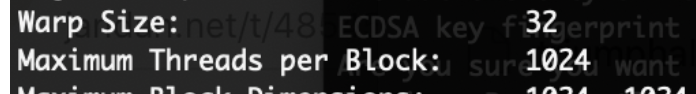

**Reference**:
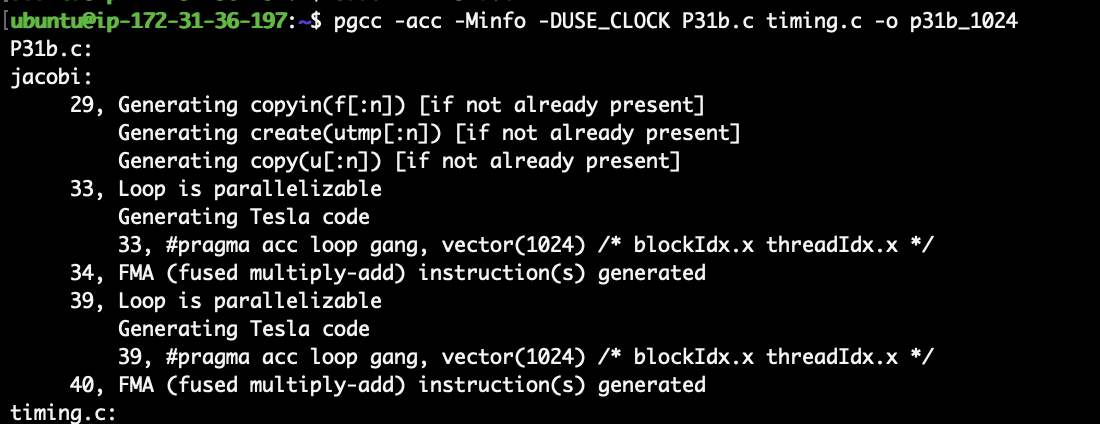
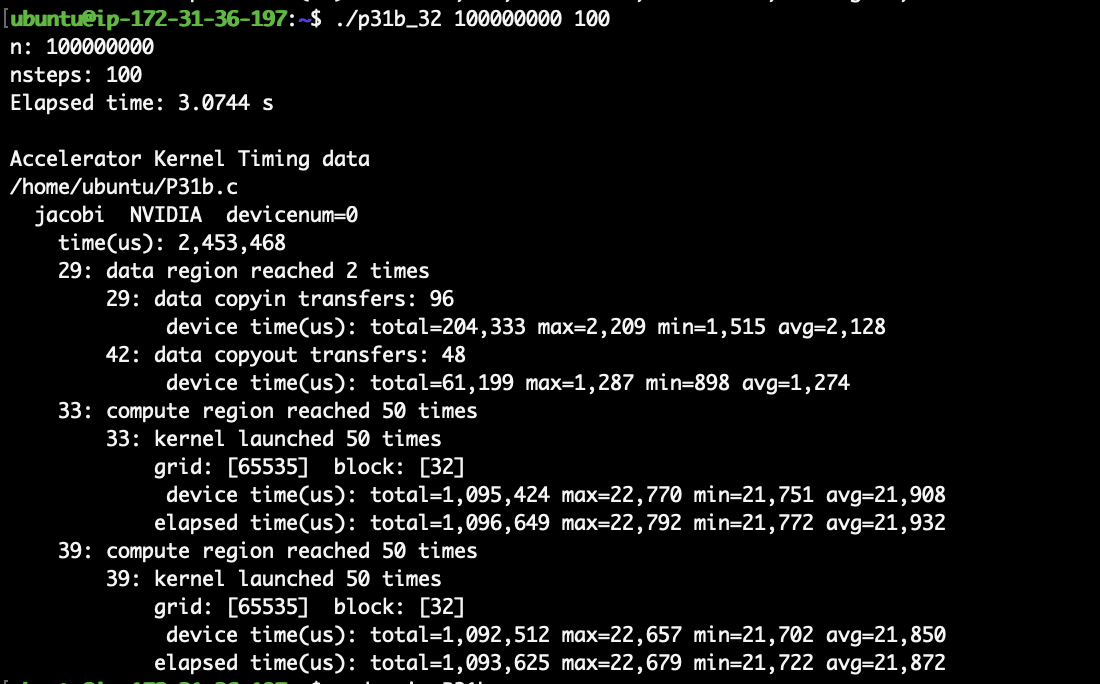
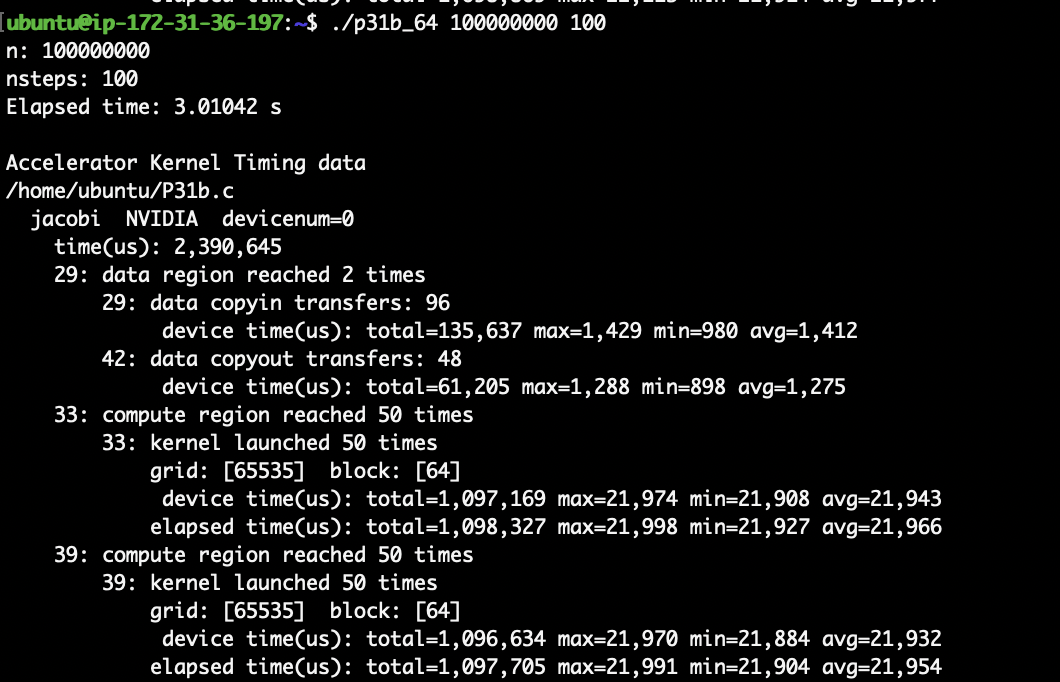
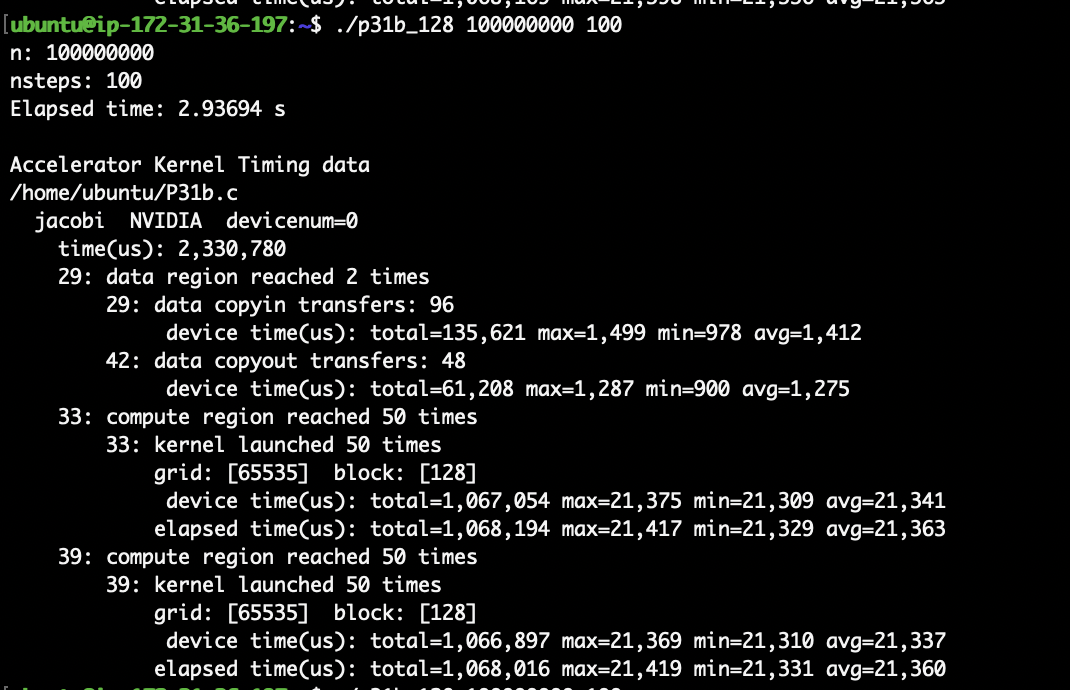
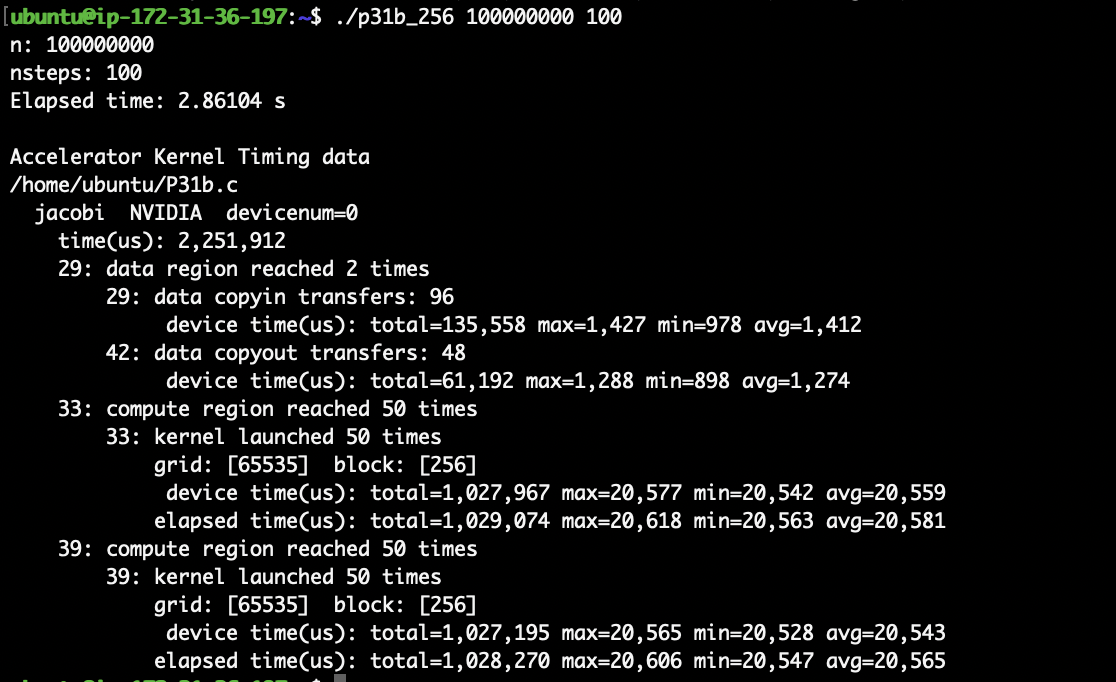
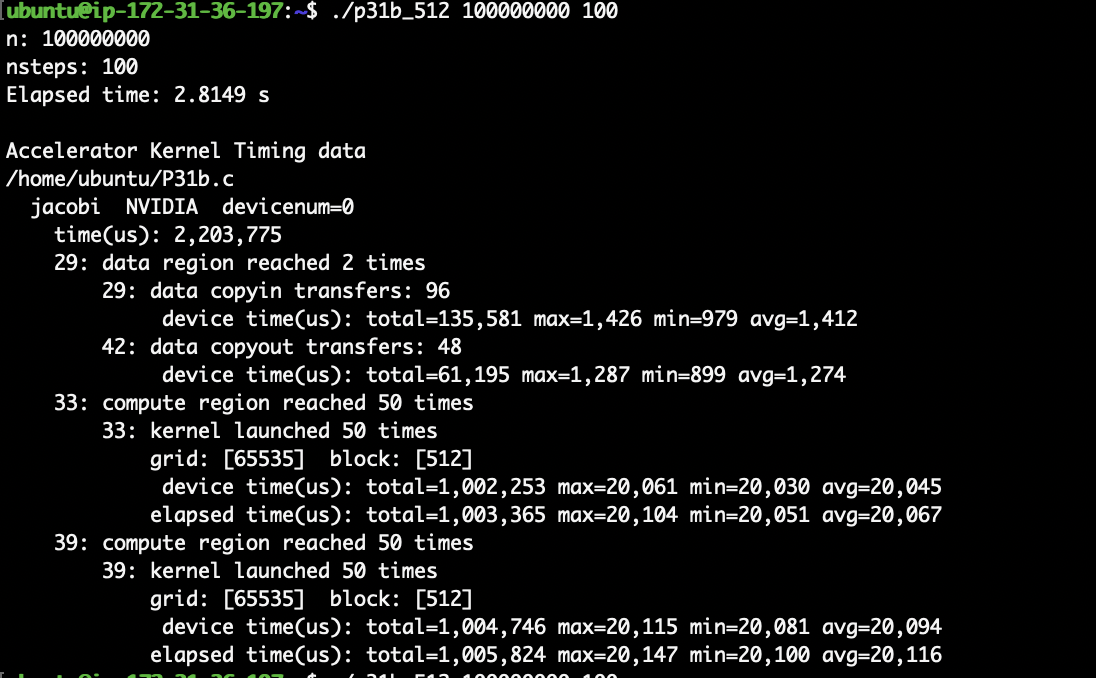
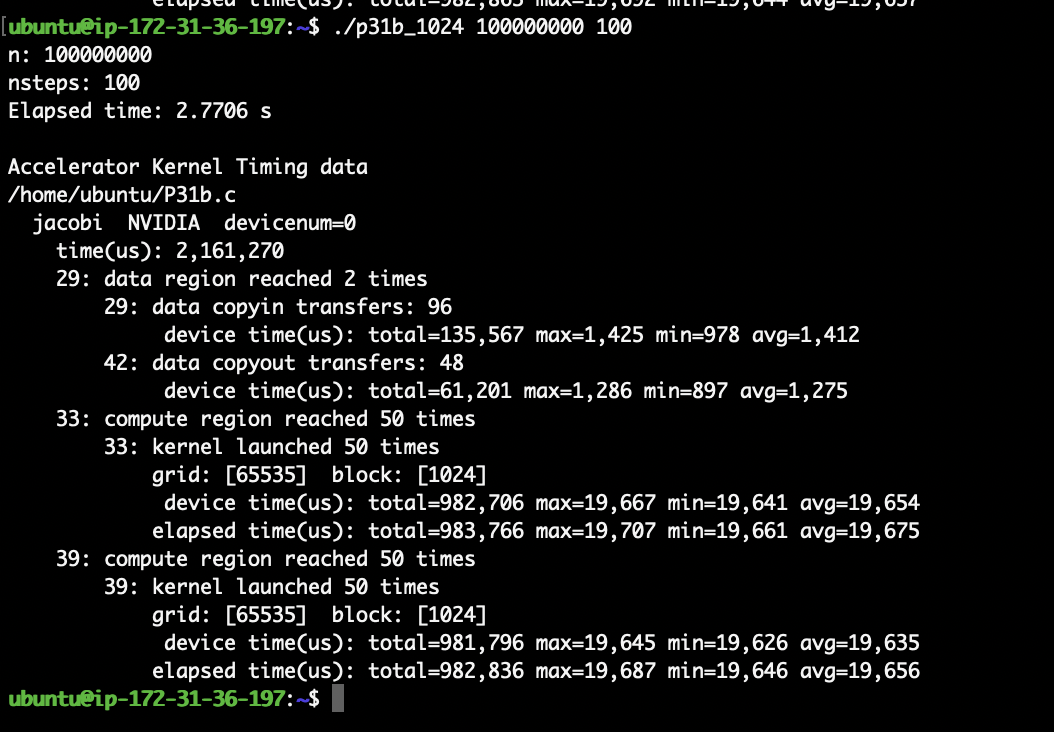